<a href="https://colab.research.google.com/github/zisserj/BPpy/blob/experimental/revised_bppy_converter_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# obtain prism
%%bash
rm -r ./*
wget -q https://www.prismmodelchecker.org/dl/prism-4.8-linux64-x86.tar.gz
gunzip prism-4.8-linux64-x86.tar.gz
tar -xf prism-4.8-linux64-x86.tar
cd prism-4.8-linux64-x86
./install.sh
bin/prism
ln -s prism-4.8-linux64-x86/bin/prism ../.

Installing PRISM (directory=/content/prism-4.8-linux64-x86)
Setting path in startup script /content/prism-4.8-linux64-x86/bin/prism...
Setting path in startup script /content/prism-4.8-linux64-x86/bin/xprism...
Installation complete.
PRISM
=====

Version: 4.8
Date: Sun Jan 07 22:22:38 UTC 2024
Hostname: d2bb77962d1b
Memory limits: cudd=1g, java(heap)=1g
Command line: prism
Usage: prism [options] <model-file> [<properties-file>] [more-options]

For more information, type: prism -help


In [ ]:
#install bppy
%%bash
wget -q https://github.com/zisserj/BPpy/archive/experimental.zip
unzip -q experimental.zip
pip install BPpy-experimental/.

Processing ./BPpy-experimental
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 8.4 MB/s eta 0:00:00
  Created wheel for bppy: filename=bppy-1.0.0-py3-none-any.whl size=31856 sha256=aa6c6655b33d1b82995094cd3cd783632e7433442ff3168b67fb450514336cbf
  Stored in directory: /root/.cache/pip/wheels/97/b7/71/9ca2eb6cb10fbeb2584fb32fef1aa1875cc685242dcc2f6862
Successfully built bppy


In [ ]:
import bppy as bp
from bppy.model.sync_statement import *
from bppy.model.b_thread import *
from bppy.analysis.bprogram_converter import BProgramConverter
from bppy.utils.dfs import DFSBProgram
import itertools

In [ ]:
class EvaluatorListener(bp.PrintBProgramRunnerListener):
    def starting(self, b_program):
        self.events = []
    def ended(self, b_program):
        pass
    def event_selected(self, b_program, event):
        self.events.append(event.name)
        if len(self.events) == 20:
            raise TimeoutError()

In [ ]:
def generate_model(DOORS_NUM=3, PRIZES_NUM=1, DOORS_OPENED_NUM=1,
                   mode=bp.execution_thread):
    if PRIZES_NUM + DOORS_OPENED_NUM >= DOORS_NUM:
        return "Invalid parameters"
    doors = [x for x in range(DOORS_NUM)]
    @mode
    def game_show(doors_num, prizes_num, doors_opened_num):
        prizes = yield choice({i: 1 / len(doors) for i in doors},
                             repeat=prizes_num, replace=False,sorted=True)
        if prizes_num == 1:
            prizes = (prizes,)
        for hide in prizes:
            yield sync(request=bp.BEvent(f'hide{hide}'))
        yield sync(request=bp.BEvent('done_hiding'))
        guess = yield sync(waitFor=[bp.BEvent(f'guess{i}') for i in doors])
        possible_opens = [d for d in doors if d not in list(prizes) + [int(guess.name[5:])]]
        dicts = {door: 1 / len(possible_opens) for door in possible_opens}
        doors_opened = yield choice(dicts, repeat=doors_opened_num,
                            replace=False, sorted=True)
        if doors_opened_num == 1:
            doors_opened = [doors_opened]
        for opened in doors_opened:
            yield sync(request=bp.BEvent(f'open{opened}'))
        yield sync(request=bp.BEvent('done_opening'))

    @mode
    def contestant(doors_num, doors_opened_num):
        yield sync(waitFor=bp.BEvent('done_hiding'))
        guess = yield choice({i: 1 / len(doors) for i in doors})
        yield sync(request=bp.BEvent(f'guess{guess}'))
        #alt starts here
        doors_opened = []
        all_doors = [bp.BEvent(f'open{o}') for o in doors]
        for i in range(doors_opened_num):
            d = yield sync(waitFor=all_doors)
            doors_opened.append(int(d.name[4:]))
        swap_options = [d for d in doors if d not in doors_opened + [guess]]
        yield sync(waitFor=bp.BEvent('done_opening'))
        swaps = [bp.BEvent(f'swap{d}') for d in swap_options]
        swap = yield choice({i: 1/len(swaps) for i in swaps})
        yield sync(request=swap)
        '''
        yield sync(waitFor=bp.BEvent('done_opening'))
        swap_options = [d for d in doors if d != guess]
        swaps = [bp.BEvent(f'swap{d}') for d in swap_options]
        yield sync(request=swaps)
        '''

    @mode
    def block_opened_doors(doors_num, doors_opened_num):
        doors_opened = []
        all_doors = [bp.BEvent(f'open{o}') for o in doors]
        for i in range(doors_opened_num):
            d = yield sync(waitFor=all_doors)
            doors_opened.append(d.name[4:])
        swap_nonoptions = [bp.BEvent(f'swap{d}') for d in doors_opened]
        yield sync(block=swap_nonoptions)

    bp_gen = lambda: bp.BProgram(bthreads=[game_show(DOORS_NUM, PRIZES_NUM, DOORS_OPENED_NUM),
                                           contestant(DOORS_NUM, DOORS_OPENED_NUM)],
                                           #block_opened_doors(DOORS_NUM, DOORS_OPENED_NUM)],
                             event_selection_strategy=bp.SimpleEventSelectionStrategy(),
                             listener=EvaluatorListener())
    event_list = ([bp.BEvent('done_hiding')] +[bp.BEvent('done_opening')] +
                  [bp.BEvent(f'{action}{i}') for action, i in itertools.product(['hide', 'guess', 'open', 'swap'], doors)])
    return bp_gen, event_list

In [ ]:
# sanity check
bp_gen, event_list = generate_model(mode=bp.execution_thread, DOORS_NUM=4,
                                    DOORS_OPENED_NUM=2, PRIZES_NUM=1)
model = bp_gen()
model.run()
print(model.listener.events)

['hide0', 'done_hiding', 'guess0', 'open1', 'open3', 'done_opening', 'swap2']


In [ ]:
from bppy.utils.dfs import Node

In [ ]:
a = Node(tuple(), sync(request=bp.BEvent('hi')))
a

(){'request': BEvent(name=hi,data={})}

In [ ]:
for i in range(3, 4):
    bp_gen, event_list = generate_model(mode=bp.analysis_thread, DOORS_NUM=i,
                                        DOORS_OPENED_NUM=1, PRIZES_NUM=1)
    dfs = DFSBProgram(bp_gen, event_list)
    init, mapper = dfs.run(explore_graph=False)
    print(f'd={i}, statessum={sum([len(bt) for bt in mapper.values()])}')

d=3, statessum=83


# Sampling evaluation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter_ns

In [ ]:
def q_params(min_doors=3,max_doors=10):
    combs = []
    for d in range(min_doors, max_doors+1):
        for p in range(1, d):
            for o in range(1, d-p):
                combs.append((d,p,o))
    return combs
combs = q_params()

In [ ]:
def sample_comb(dpo=(3,1,1), gen_function=generate_model, max_run=10000):
    d,p,o = dpo
    bp_gen, _ = gen_function(d, p, o, mode=bp.execution_thread)
    hist = []
    times = []
    std = []
    start_time = perf_counter_ns()
    for i in range(max_run):
        model = bp_gen()
        model.run()
        res = model.listener.events
        prizes = [d[4:] for d in res[:p]]
        hist.append(int(res[-1][4:] in prizes))
        times.append(perf_counter_ns()-start_time)
    return(hist, times)

In [ ]:
#results = {sample_comb(run) fo}
hist, times = sample_comb((10,2,6))

In [ ]:
avg = np.array([np.mean(hist[0:i]) for i in range(1,len(hist))])
std = np.array([np.std(avg[0:i]) for i in range(len(avg))])

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
avg[-1]

0.596959695969597

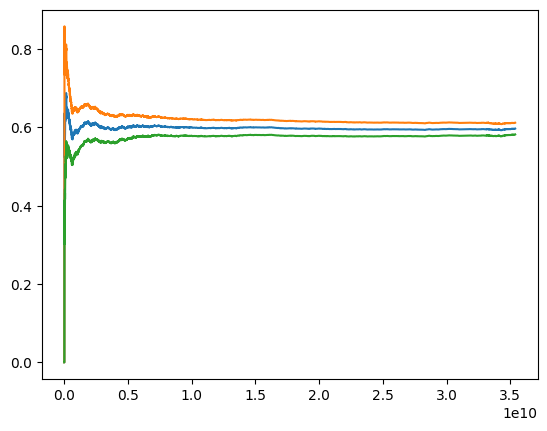

In [ ]:
plt.plot(times[1:], avg)
plt.plot(times[1:], avg+std)
plt.plot(times[1:], avg-std)

# Translation evaluation

In [ ]:
bp_gen, event_list = generate_model(DOORS_NUM=10,
                                    PRIZES_NUM=1,
                                    DOORS_OPENED_NUM=1,
                                    mode=bp.analysis_thread)
event_nums = {e.name: i for i, e in enumerate(event_list)}
conv = BProgramConverter(bp_gen, event_list)
output = conv.to_prism('monty.prism')

swap_wins = [(event_nums[f'hide{i}'], event_nums[f'swap{i}']) for i in range(4)]
prop_swap = " | ".join([f'((F event={h}) & (F event={s}))' for h, s in swap_wins])
prop_swap
with open("prop.csl", 'w+') as f:
    f.write(f"filter(print, Pmax=? [{prop_swap}])")

In [ ]:
!cat prop.csl

In [ ]:
!./prism --help

In [ ]:
!./prism monty.prism prop.csl -cuddmaxmem 3g -javamaxmem 4g -javastack 500m -nodasimplify

In [ ]:
!./prism monty.prism -simpath '12,probs=true' stdout

In [ ]:
!cat monty.prism

In [ ]:
a == b